This notebook will generate a few plots useful to demonstrating the agreement between the SIR ODE's and the nSIR model in some limited cases where the ODE's hold. Most of this code is simply from other files.

In [1]:
# ODE

import SIR_model as sir
import network_manipulation as nm
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random
import time
import network_stats as ns

dataset_paths = [
'Sociopatterns datasets/conference_2009.dat_',
'Sociopatterns datasets/highschool_2011.csv',
'Sociopatterns datasets/highschool_2012.csv',
'Sociopatterns datasets/highschool_2013.csv',
'Sociopatterns datasets/hospital_2010.dat_',
'Sociopatterns datasets/primaryschool_2014.csv',
'Sociopatterns datasets/workplace_2013.dat',
'Sociopatterns datasets/workplace_2015.dat_']

dataset_names = [
    'Conference 1', 
    'Highschool 1', 
    'Highschool 2', 
    'Highschool 3', 
    'Hospital 1', 
    'Primaryschool 1', 
    'Workplace 1', 
    'Workplace 2']

simulation_params = {}
simulation_params['Time'] = 50
simulation_params['Runs'] = 500
simulation_params['Initial'] = 0.05
simulation_params['Beta'] = 0.8
simulation_params['Gamma'] = 0.2
simulation_params['Threshold'] = 65*2 # only affects simulation
simulation_params['Scheme'] = 'random'


original_beta = simulation_params['Beta']
connectivity = 0.137

G = nm.build_nxgraph(dataset_paths[2], True) # un-normalised weighted networkx graph
N = len(G) 

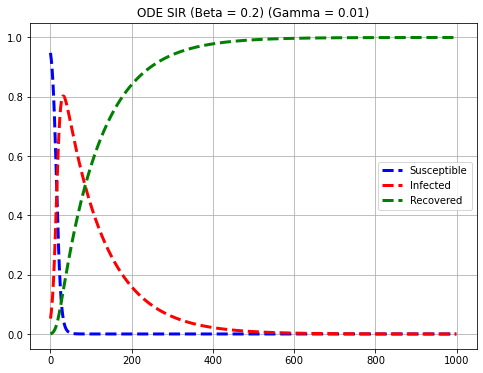

In [81]:
# ODE
plt.figure(figsize=(8, 6))
plt.grid()
simulation_params['Beta'] = 0.2
simulation_params['Gamma'] = 0.01
simulation_params['Time'] = 1000
analytic_time = np.arange(0, simulation_params['Time'])
S, I, R = sir.analytic_sol(G, simulation_params)

plt.plot(analytic_time, S, linewidth = 3, label = 'Susceptible', color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(analytic_time, I, linewidth = 3, label = 'Infected', color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(analytic_time, R, linewidth = 3, label = 'Recovered', color = 'g', linestyle = 'dashed', alpha = 1)

plt.title('ODE SIR (Beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ')')
plt.legend(loc = 'center right')

plt.show()

In [4]:
def test_sir(H, params): # propogation algorithm for basic SIR on network
    update_dict = {}
    nodes = list(H.nodes)
    for node in nodes:
        if H.nodes[node]['status'] == 0:
            connections = list(H.neighbors(node))
            connection = random.choice(connections)
            if H.nodes[connection]['status'] == 1:
                stat = H[node][connection]['weight'] * params['Beta']
                #if stat < 0.01:
                    #print(stat)
                if np.random.random() < stat:
                    update_dict[connection] = 0
                    
    for node in list(H.nodes):
        if H.nodes[node]['status'] == 0:
            if np.random.random() < params['Gamma']:
                H.nodes[node]['status'] = -1
    
    for node in list(update_dict.keys()):
        H.nodes[node]['status'] = 0  
    
    return H
    
def simulate_sir(H, params):
    H = sir.initialise_potential(H, params)
    H = sir.initialise_status(H)
    S = []
    I = []
    R = []
    s, i, r = sir.check_states(H)
    S.append(s)
    I.append(i)
    R.append(r)
    for i in range(params['Time']):
        H = test_sir(H, params)
        s, i, r = sir.check_states(H)
        S.append(s)
        I.append(i)
        R.append(r)
    return S, I, R

def smooth_basic(H, params):
    s_smooth = []
    i_smooth = []
    r_smooth = []
    s_runs = []
    i_runs = []
    r_runs = []
    
    M = params['Runs']
    T = params['Time']
    
    for i in range(M):
        #print(i)
        #print(str(round((i+1)*100/M, 1)) + '%') # display progress of smoothing
        s_run, i_run, r_run = simulate_sir(H, params)
        s_runs.append(s_run)
        i_runs.append(i_run)
        r_runs.append(r_run)
    
    for i in range(T): # smoothing susceptible time series
        total = 0
        for j in range(M):
            total += s_runs[j][i]     
        total = total / M   
        s_smooth.append(total)
        
    for i in range(T): # smoothing infected time series
        total = 0
        for j in range(M):
            total += i_runs[j][i]     
        total = total / M   
        i_smooth.append(total)

    for i in range(T): # smoothing recovered time series
        total = 0
        for j in range(M):
            total += r_runs[j][i]     
        total = total / M   
        r_smooth.append(total)
        
    return s_smooth, i_smooth, r_smooth

In [5]:

def weighted_beta(G, original_beta): # takes the orginal beta and returns an equivalent for a weighted network
    nodes = list(G.nodes)
    total = 0
    for node in nodes:
        connections = list(G.neighbors(node))
        subtotal = 0
        for connection in connections:
            subtotal += G[node][connection]['weight']
        total += (subtotal / len(connections))
    return original_beta * (total / len(G)) # need to divide by len(G) to give average over graph

def normalize_weights(G):
    # find the maximum weight
    max_weight = max([G[node1][node2]['weight'] for node1, node2 in G.edges])
    # normalize the weights
    for node1, node2 in G.edges:
        G[node1][node2]['weight'] /= max_weight
    return G

In [6]:
# find at which index the numerical solution stops changing
# slice both numerical and analytitcal and compare over this range

def check_steady(arr):
    # Iterate over the array comparing adjacent elements
    for i in range(len(arr) - 1):
        if abs(arr[i] - arr[i+1]) < 0.0001:
            steady =  True
            break
        else:
            steady = False      
    if steady:
        return steady, i+1
    else:
        return steady, i+2

def find_slice(curve1, curve2):
    inds = []
    inds.append(check_steady(curve1)[1])
    inds.append(check_steady(curve2)[1])
    return (max(inds))

def steady_slice(curve1, curve2):
    steady_index = find_slice(curve1, curve2)
    curve1 = curve1[0:steady_index]
    curve2 = curve2[0:steady_index]
    return curve1, curve2

In [7]:

import numpy as np
import matplotlib.pyplot as plt

def dynamic_time_warping(curve1, curve2): # Compute the similarity using dynamic time warping (DTW)
    n = len(curve1)
    m = len(curve2)
    dtw_matrix = np.zeros((n+1, m+1))
    dtw_matrix[1:, 0] = np.inf
    dtw_matrix[0, 1:] = np.inf
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(curve1[i-1] - curve2[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])
    dtw_distance = dtw_matrix[-1, -1]
    return dtw_distance, dtw_matrix

def find_warping_path(curve1, curve2): # Plot the two curves and the warping path
    _, dtw_matrix = dynamic_time_warping(curve1, curve2)
    n = len(curve1)
    m = len(curve2)
    warping_path = []
    i, j = n, m
    while i > 0 and j > 0:
        warping_path.append((i-1, j-1))
        if dtw_matrix[i-1, j] == min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]):
            i -= 1
        elif dtw_matrix[i, j-1] == min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]):
            j -= 1
        else:
            i -= 1
            j -= 1
    warping_path.reverse()
    return warping_path

def plot_warping_path(curve1, curve2):
    plt.plot(curve1, label='Analytical')
    plt.plot(curve2, label='Numerical')
    warping_path = find_warping_path(curve1 ,curve2)
    for i, j in warping_path:
        plt.plot([i, j], [curve1[i], curve2[j]], alpha = 0.25, color ='b')
    plt.legend()
    plt.show()

def integrate_curve(curve):
    # Calculate the cumulative sum of the curve
    integrated_curve = np.cumsum(curve)
    # Return the final value
    return integrated_curve[-1]

def dtw_similarity(curve1, curve2, plot = False): # curve1 - numerical, curve2 - analytical
    analytical_integration = integrate_curve(curve2)
    if analytical_integration == 0:
        similarity = 1
    else:
        dtw_distance, _ = dynamic_time_warping(curve1, curve2)
        similarity = 1 - (dtw_distance / analytical_integration)
    if plot:
        plt.title("DTW similarity:" + str(round(similarity, 3)))
        plot_warping_path(curve1, curve2)
    return similarity

def euclidean_similarity(curve1, curve2):
    analytical_integration = integrate_curve(curve2)
    if analytical_integration == 0:
        similarity = 1
    else:
        similarity = 1 - (np.linalg.norm(np.array(curve1) - np.array(curve2)) / analytical_integration)
    return similarity

def pearson_correlation(curve1, curve2, plot = False):
    correlation = np.corrcoef(curve1, curve2)[0, 1]
    if plot:
        plt.plot(curve1, label='Numerical')
        plt.plot(curve2, label='Analytical')
        plt.title("Correlation coefficient:" + str(round(correlation, 3)))
        plt.legend()
        plt.show()
    return correlation

def total_similarity(curve1, curve2):
    dtw = dtw_similarity(curve1, curve2, 0)
    euc = euclidean_similarity(curve1, curve2)
    return (dtw + euc) / 2

# Define two sample curves to compare
#curve1 = np.array([0, 10, 30, 50, 80, 110, 120, 130, 140, 150])
#curve2 = np.array([0, 5, 25, 45, 80, 100, 120, 130, 140, 150])
#dtw_similarity(curve1, curve2, 1)

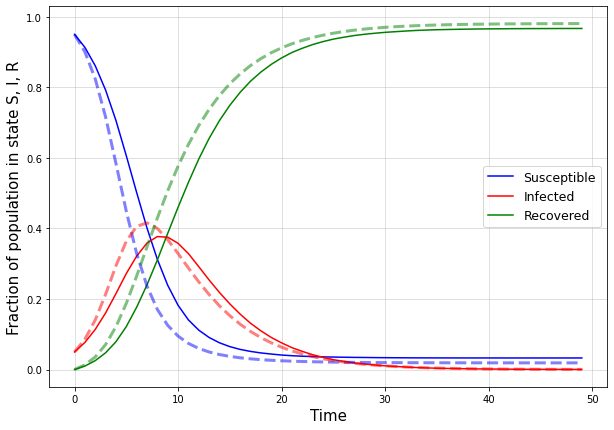

In [3]:
# ODE vs complete network (unweighted graph)

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = sir.initialise_weight(H, 1) # give every edge a weight of 1

s, i, r = smooth_basic(H, simulation_params)
S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (10,7))
#plt.title('Conventional SIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ')')

# numerical
plt.plot(t, s, label = 'Susceptible', color = 'b', lw = 1.5)
plt.plot(t, i, label = 'Infected', color = 'r', lw = 1.5)
plt.plot(t, r, label = 'Recovered', color = 'g', lw = 1.5)

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 0.5)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 0.5)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 0.5)

plt.legend(fontsize = 12.5)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Fraction of population in state S, I, R', fontsize = 15)
plt.grid(alpha = 0.5)


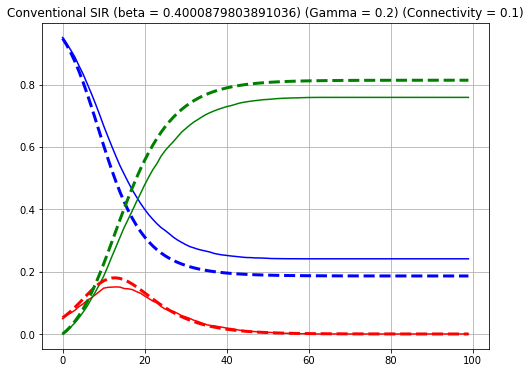

In [6]:
# ODE vs complete network (randomly weighted graph)

def initialise_weight_random(G): # Sets weight to all edges to 'weight'
    nodes = list(G.nodes)
    for node in nodes:
        connections = list(G.neighbors(node))
        for connection in connections:
            G[node][connection]['weight'] = random.random()
    return G

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_random(H)
H = normalize_weights(H)

simulation_params['Beta'] = original_beta
s, i, r = smooth_basic(H, simulation_params)
simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])
S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('Conventional SIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.grid()

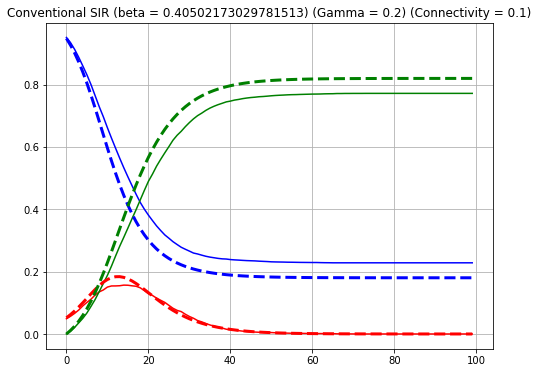

In [7]:
# ODE vs complete network (linear weighted graph)

def initialise_weight_linear(G): # Sets weight to all edges to 'weight'
    nodes = list(G.nodes)
    for node in nodes:
        connections = list(G.neighbors(node))
        for connection in connections:
            G[node][connection]['weight'] = ns.linear(random.random(), -1, 1)
    return G

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_linear(H)
H = normalize_weights(H)

simulation_params['Beta'] = original_beta
s, i, r = smooth_basic(H, simulation_params)
simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])
S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('Conventional SIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.grid()

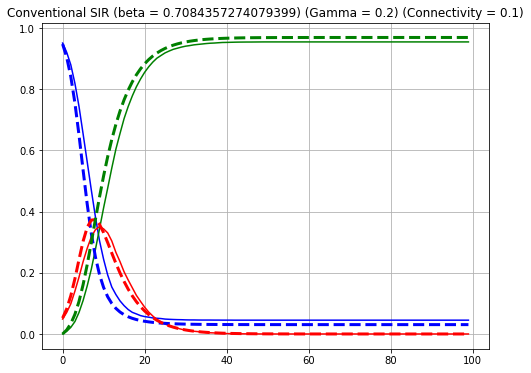

In [8]:
# ODE vs complete network (exponential weighted graph)

def initialise_weight_exponential(G): # Sets weight to all edges to 'weight'
    nodes = list(G.nodes)
    for node in nodes:
        connections = list(G.neighbors(node))
        for connection in connections:
            G[node][connection]['weight'] = ns.exponential(random.random(), .25, 4)
    return G

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_exponential(H)
H = normalize_weights(H)

simulation_params['Beta'] = original_beta
s, i, r = smooth_basic(H, simulation_params)
simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])
S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('Conventional SIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.grid()

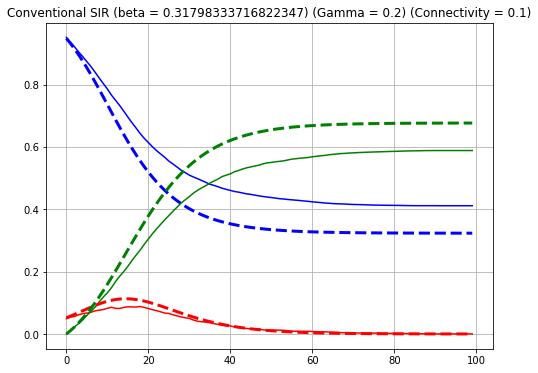

In [10]:
# ODE vs complete network (power weighted graph)

def initialise_weight_power(G): # Sets weight to all edges to 'weight'
    nodes = list(G.nodes)
    for node in nodes:
        connections = list(G.neighbors(node))
        for connection in connections:
            G[node][connection]['weight'] = ns.power(random.random(), 10, 1.5)
    return G

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_power(H)
H = normalize_weights(H)

simulation_params['Beta'] = original_beta
s, i, r = smooth_basic(H, simulation_params)
simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])
S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('Conventional SIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.grid()

# For higher +ve powers (about 4 or higher), a greater fraction of weights are close to zero which leads to a lack of spread of infection
# For -ve powers, there is increased infection seen as compared to the base case as on interval [0,1] the weight is greater than 1 which increases the chance of infection
# When modulating the coefficient of the power law we then begin to see lower infection as we would expect as the function is not always greater than 1


After trying these weighting schemes it is clear that there is some leeway within which the basic SIR spread on weighted networks will agree with the ODE solutions

I need to define some metric to calculate the similarity between the two sets of curves and use this to give a more rigourous range of weighting parameter values for which there is agreement with the ODE's

However, a conclusion is, generally, for weighted networks the ODE model is not a good fit (this should be clear anyway as what we are doing is effectively changing the beta value of the sysem - in this regard, does it make sense to always change the beta value to be less than the original or should we also acount for potential increases ... rather I think it makes more sense for the original beta value to be thought of as an average for the system and then weights that are added should be sampled from a normal distribution - this will retain characteristics [for certain beta values at least] but is this really what we mean by beta ... after doing a quick chatGPT, \beta is defined as: 'beta = lambda * sum(w_ij * A_ij) / k_i,' so in weighted network models what I think of beta is really lambda which gets scaled by the network structure to give the same overall beta parameter - I believe this is a requirement to keep consistent with the behaviour we expect from a disease. This is the next step forwards for our modelling).

After implementing the modulated beta value we will need implement n-SIR model

Additionally, the effects of decreasing the connectivity of the graph remains about the same despite changing the weights.

0.0949062999622494


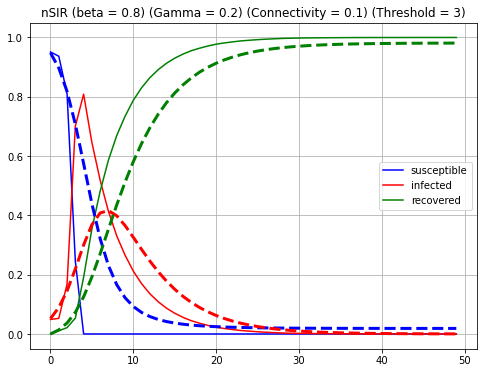

In [777]:
# nSIR on exponentially weighted network

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_exponential(H)
H = normalize_weights(H)
H = sir.initialise_potential(H, simulation_params)
H = sir.initialise_status(H)

simulation_params['Threshold'] = 3
simulation_params['Runs'] = 100

simulation_params['Beta'] = original_beta
s, i, r = sir.smooth(H, simulation_params)
simulation_params['Gamma'] = 0.2

#simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])
S, I, R = sir.analytic_sol(H, simulation_params)

t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('nSIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ') (Threshold = ' + str(simulation_params['Threshold']) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.legend(loc = 'center right')
plt.grid()


0.018454351192471293


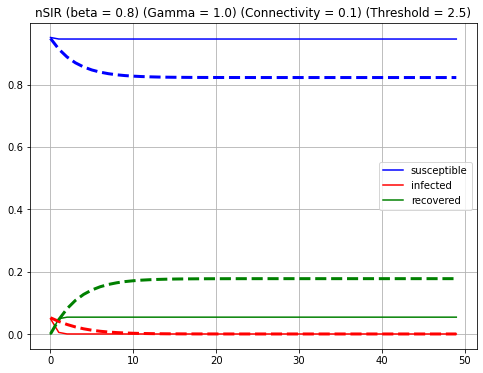

In [774]:
# nSIR on randomly weighted network

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_random(H)
H = normalize_weights(H)
H = sir.initialise_potential(H, simulation_params)
H = sir.initialise_status(H)

simulation_params['Threshold'] = 2.5
simulation_params['Runs'] = 100
simulation_params['Beta'] = original_beta


s, i, r = sir.smooth(H, simulation_params)
#simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])
S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('nSIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ') (Threshold = ' + str(simulation_params['Threshold']) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.legend(loc = 'center right')
plt.grid()

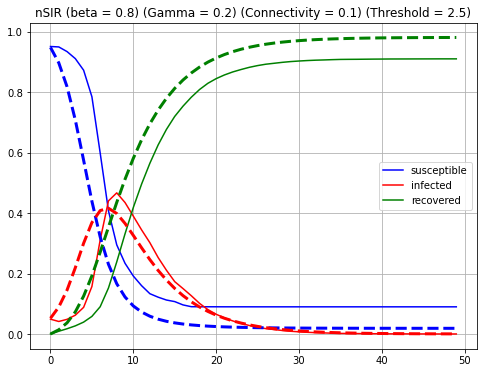

In [805]:
# nSIR on power law weighted network

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_power(H)
H = normalize_weights(H)
H = sir.initialise_potential(H, simulation_params)
H = sir.initialise_status(H)

simulation_params['Threshold'] = 2.5
simulation_params['Runs'] = 100
simulation_params['Beta'] = original_beta
simulation_params['Gamma'] = 0.2

s, i, r = sir.smooth(H, simulation_params)

simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])

S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('nSIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ') (Threshold = ' + str(simulation_params['Threshold']) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.legend(loc = 'center right')
plt.grid()

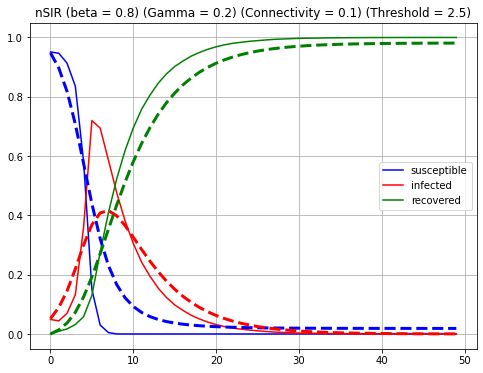

In [806]:
# nSIR on linear weighted network

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_linear(H)
H = normalize_weights(H)
H = sir.initialise_potential(H, simulation_params)
H = sir.initialise_status(H)

simulation_params['Threshold'] = 2.5
simulation_params['Runs'] = 100
simulation_params['Beta'] = original_beta

s, i, r = sir.smooth(H, simulation_params)

#simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])

S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('nSIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ') (Threshold = ' + str(simulation_params['Threshold']) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.legend(loc = 'center right')
plt.grid()


In [20]:
# basic SIR for comparison

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = sir.initialise_weight(H, 1) # give every edge a weight of 1
H = sir.initialise_potential(H, simulation_params)
H = sir.initialise_status(H)

simulation_params['Beta'] = 0.8
simulation_params['Gamma'] = 0.2
simulation_params['Threshold'] = 7
simulation_params['Runs'] = 10
simulation_params['Time'] = 50

bS, bI, bR = smooth_basic(H, simulation_params)

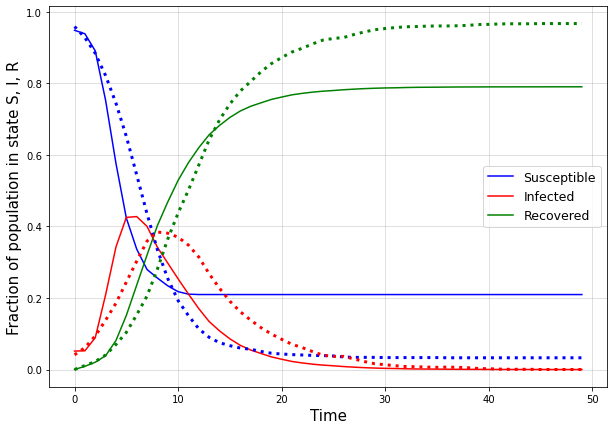

In [29]:
# nSIR on unweighted network

simulation_params['Threshold'] = 4
simulation_params['Runs'] = 100
simulation_params['Scheme'] = 'random'

s, i, r = sir.smooth(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (10,7))
#plt.title('nSIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ') (Threshold = ' + str(round(simulation_params['Threshold'], 2)) + ')')

# numerical
plt.plot(t, s, label = 'Susceptible', color = 'b', lw = 1.5)
plt.plot(t, i, label = 'Infected', color = 'r', lw = 1.5)
plt.plot(t, r, label = 'Recovered', color = 'g', lw = 1.5)

# analytic
#plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 0.5)
#plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 0.5)
#plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 0.5)

# basic
plt.plot(t, bS, linewidth = 3, color = 'b', linestyle = 'dotted', alpha = 1)
plt.plot(t, bI, linewidth = 3, color = 'r', linestyle = 'dotted', alpha = 1)
plt.plot(t, bR, linewidth = 3,  color = 'g', linestyle = 'dotted', alpha = 1)

plt.legend(fontsize = 12.5)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Fraction of population in state S, I, R', fontsize = 15)
plt.grid(alpha = 0.5)

(0.8664444444444445, 0.033107374882417634)
(0.6919999999999997, 0.02695152484291055)
(5.51, 0.32939186389466274)
0.839
0.45799999999999996
6


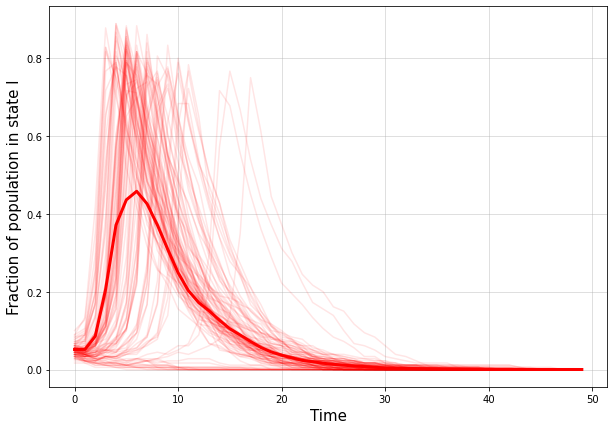

In [33]:
# nSIR on unweighted network

def metric(arr):
    arr = np.array(arr)
    err = np.std(arr) / np.sqrt(len(arr))
    val = np.mean(arr)
    return val, err

simulation_params['Threshold'] = 4
simulation_params['Runs'] = 1
runs = 100

#simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])
S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (10,7))
#plt.title('nSIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ') (Threshold = ' + str(round(simulation_params['Threshold'], 2)) + ')')

outbreak_size = []
infection_peak = []
time_to_peak = []

# numerical
for i in range(runs):
    s, i, r = sir.smooth(H, simulation_params)
    plt.plot(t, i, label = 'Infected', color = 'r', lw = 1.5, alpha = 0.1)
    i = np.array(i)
    i_size = r[-1]
    i_max = np.amax(i)
    i_max_time = np.argmax(i)
    
    outbreak_size.append(i_size)
    infection_peak.append(i_max)
    time_to_peak.append(i_max_time)
    
    #plt.plot(t, s, label = 'Susceptible', color = 'b', lw = 1.5, alpha = 0.25)
    #plt.plot(t, r, label = 'Recovered', color = 'g', lw = 1.5)

print(metric(outbreak_size))
print(metric(infection_peak))
print(metric(time_to_peak)) 

simulation_params['Runs'] = runs
s, i, r = sir.smooth(H, simulation_params)
plt.plot(t, i, label = 'Infected', color = 'r', lw = 3, alpha = 1)
#plt.plot(t, s, label = 'Susceptible', color = 'b', lw = 1.5, alpha = 0.25)
#plt.plot(t, r, label = 'Recovered', color = 'g', lw = 1.5)

#plt.plot(t, bS, linewidth = 3, color = 'b', linestyle = 'dotted', alpha = 1)
#plt.plot(t, bI, linewidth = 3, color = 'r', linestyle = 'dotted', alpha = 1)
#plt.plot(t, bR, linewidth = 3,  color = 'g', linestyle = 'dotted', alpha = 1)

print(r[-1])
print(np.amax(i))
print(np.argmax(i))

plt.xlabel('Time', fontsize = 15)
plt.ylabel('Fraction of population in state I', fontsize = 15)
plt.grid(alpha = 0.5)

In [446]:
node_measures = ns.measure_nodes(G)
network_measures = ns.measure_network(G)
ns.print_dict(node_measures)
ns.print_dict(network_measures)

degree : 24.666666666666668
weight : 0.01585268862612613
closeness : 84.65309407617765
betweenness : 1.1606302178143244
eigenvector : 11.835303981613764


nodes : 180
edges : 2220
ratio : 12.333333333333334
components : 1
density : 0.1378026070763501
path : 2.1477343265052764
diameter : 4
transitivity : 0.4341438783077967




DTW


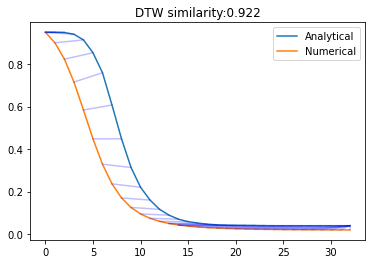

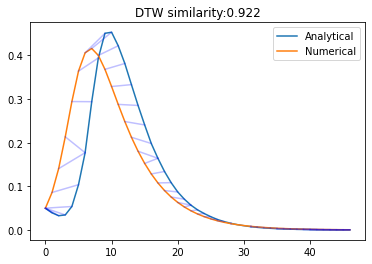

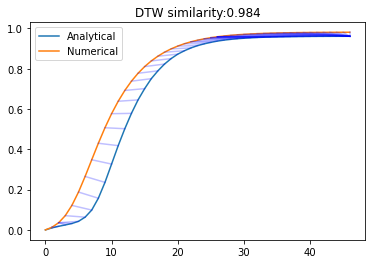

0.9220928614288764
0.9224930158555954
0.9840262865762099
0.9428707212868939

 Euclidean
0.8504933807699488
0.8812517713644223
0.9799050137929474
0.9038833886424396

Correlation
0.9427527544073129
0.8026395542046092
0.9792062726530765
0.9081995270883328


In [218]:
s, S = steady_slice(s, S)
i, I = steady_slice(i, I)
r, R = steady_slice(r, R)

print('DTW')
s_sim = dtw_similarity(s, S, 1)
i_sim = dtw_similarity(i, I, 1)
r_sim = dtw_similarity(r, R, 1)
print(s_sim)
print(i_sim)
print(r_sim)
total_sim = (s_sim+i_sim+r_sim) / 3
print(total_sim)

print('\n Euclidean')
s_euclidean = euclidean_similarity(s, S)
i_euclidean = euclidean_similarity(i, I)
r_euclidean = euclidean_similarity(r, R)
print(s_euclidean)
print(i_euclidean)
print(r_euclidean)
total_euclidean = (s_euclidean + i_euclidean + r_euclidean) / 3
print(total_euclidean)

print('\nCorrelation')
s_correlation = pearson_correlation(s, S, 0)
i_correlation = pearson_correlation(i, I, 0)
r_correlation = pearson_correlation(r, R, 0)
print(s_correlation)
print(i_correlation)
print(r_correlation)
total_correlation = (s_correlation + i_correlation + r_correlation) / 3
print(total_correlation)

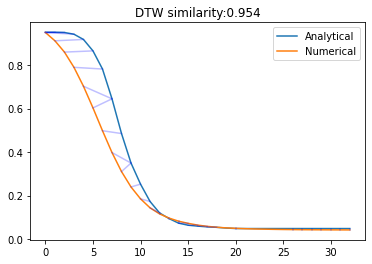

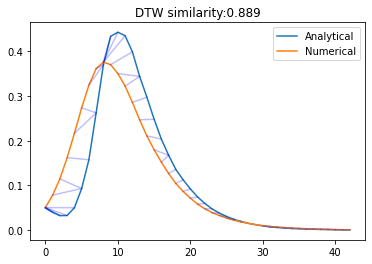

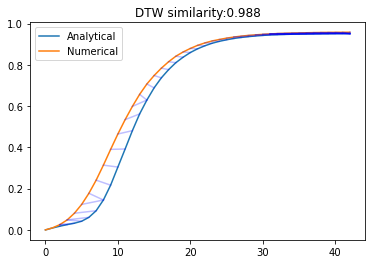

DTW
0.954474033603011
0.8893316379180405
0.9883317108538023
0.9440457941249513

 Euclidean
0.9250585177259194
0.9090383948833
0.9855328755021173
0.9398765960371124

Correlation
0.9789358276363642
0.8807749266446468
0.9918227987128059
0.9505111843312722


In [250]:
s, S = steady_slice(s, bS)
i, I = steady_slice(i, bI)
r, R = steady_slice(r, bR)


s_sim = dtw_similarity(s, S, 1)
i_sim = dtw_similarity(i, I, 1)
r_sim = dtw_similarity(r, R, 1)
print('DTW')
print(s_sim)
print(i_sim)
print(r_sim)
total_sim = (s_sim+i_sim+r_sim) / 3
print(total_sim)

print('\n Euclidean')
s_euclidean = euclidean_similarity(s, S)
i_euclidean = euclidean_similarity(i, I)
r_euclidean = euclidean_similarity(r, R)
print(s_euclidean)
print(i_euclidean)
print(r_euclidean)
total_euclidean = (s_euclidean + i_euclidean + r_euclidean) / 3
print(total_euclidean)

print('\nCorrelation')
s_correlation = pearson_correlation(s, S, 0)
i_correlation = pearson_correlation(i, I, 0)
r_correlation = pearson_correlation(r, R, 0)
print(s_correlation)
print(i_correlation)
print(r_correlation)
total_correlation = (s_correlation + i_correlation + r_correlation) / 3
print(total_correlation)

V = 6.778

DTW
0.9147622095077989
0.860580742893358
0.9842669085221185
0.9198699536410917

 Euclidean
0.9483465701739605
0.9279756112296209
0.9917654744972585
0.9560292186336133

Correlation
0.9898381823153328
0.9427298268620681
0.9972454623179648
0.9766044904984552

V = 6.868

DTW
0.9042980428490927
0.8396000572009421
0.9819836954678878
0.9086272651726408

 Euclidean
0.9498271405255925
0.9276694416450509
0.9921937998945514
0.9565634606883983

Correlation
0.9896622580483396
0.9516649017417241
0.9977900315986615
0.9797057304629084

In [252]:
# This is not working as intended ... PROBLEM

import numpy as np
from scipy.optimize import minimize_scalar

# Define the function you want to maximize

def total_similarity(curve1, curve2):
    dtw = dtw_similarity(curve1, curve2, 0)
    euc = euclidean_similarity(curve1, curve2)
    return (dtw + euc) / 2
    

def my_func(threshold):
    simulation_params['Threshold'] = threshold
    simulation_params['Runs'] = 100
    # Generate a time series from the parameter
    s, i, r = sir.smooth(H, simulation_params)
    #simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])
    #S, I, R = sir.analytic_sol(H, simulation_params)
    #S, I, R = smooth_basic(H, simulation_params)
    # Calculate the value of the function using the time series and the data

    s, temp_S = steady_slice(s, bS)
    i, temp_I = steady_slice(i, bI)
    r, temp_R = steady_slice(r, bR)
  
    s_sim = total_similarity(s, temp_S)
    i_sim = total_similarity(i, temp_I)
    r_sim = total_similarity(r, temp_R)

    value = (s_sim + i_sim + r_sim) / 3
    
    print(value)

    # Return the negative value (to maximize instead of minimize)
    return -value



# Find the value of the parameter that maximizes the function
result = minimize_scalar(my_func, bounds=(7.75, 8.25), method='bounded')
min_val = -result.fun
opt_param = result.x

# Calculate the inverse Hessian and extract the diagonal elements
#hess_inv = result.hess_inv
#cov = hess_inv.todense()
#std_errs = np.sqrt(np.diag(cov))

# Print the results
print('\nMinimum value:', min_val)
print('Optimal parameter:', opt_param)
#print('Standard errors:', std_errs)

'''
After running for 6 mins: 4.708203938677366
But this gave terrible agreement!

After switching to bounded approach to avoid local minima it is working a bit better.
'''

0.9413252788023337
0.9309549667560234
0.9453989444538019
0.936301477107595
0.9321130041153026
0.9372535813466193
0.9439045579689317
0.9376487413714614
0.9307511566138795
0.9395293933926446
0.9290920428808528
0.9295765770797274
0.9439726816114029
0.9371718129023204
0.9438627860797609
0.9226056195193159
0.934600161977019
0.9358892299830436
0.9423948542366843
0.94418111366156
0.9318665685511723
0.9333305202735641
0.9424034547470939
0.9432624214996431

Minimum value: 0.9453989444538019
Optimal parameter: 7.868033988749895


'\nAfter running for 6 mins: 4.708203938677366\nBut this gave terrible agreement!\n\nAfter switching to bounded approach to avoid local minima it is working a bit better.\n'

In [425]:
s, S = steady_slice(s, bS)
i, I = steady_slice(i, bI)
r, R = steady_slice(r, bR)

s_sim = total_similarity(s, S)
i_sim = total_similarity(i, I)
r_sim = total_similarity(r, R)
print('DTW')
print(s_sim)
print(i_sim)
print(r_sim)
total_sim = (s_sim+i_sim+r_sim) / 3
print(total_sim)

DTW
0.9494351779845918
0.8977269998326103
0.9912148754751031
0.9461256844307684


In [7]:
# Algorithm to find bounds for scipy minimize_scalar

simulation_params['Beta'] = 0.8
simulation_params['Gamma'] = 0.2
simulation_params['Runs'] = 50
simulation_params['Time'] = 50

threshold_list = np.arange(1, 10.1, 0.5)

similarity_list = []

for l in threshold_list:
    print(l)
    simulation_params['Threshold'] = l
    s, i, r = sir.smooth(H, simulation_params)
    
    s, temp_S = steady_slice(s, bS)
    i, temp_I = steady_slice(i, bI)
    r, temp_R = steady_slice(r, bR)
    
    s_sim = total_similarity(s, temp_S)
    i_sim = total_similarity(i, temp_I)
    r_sim = total_similarity(r, temp_R)
    
    avg_sim = (s_sim + i_sim + r_sim) / 3
    
    similarity_list.append(avg_sim)
    
threshold_list = np.array(threshold_list)
similarity_list = np.array(similarity_list)
    
print('Best similarity: ', np.amax(similarity_list))
print('Best threshold: ', threshold_list[np.argmax(similarity_list)])

1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5
10.0
Best similarity:  0.908263052635788
Best threshold:  3.5


# Heatmaps

In [314]:
# plotting similarity data on a heatmap
# not sure if axis are labelled correctly

import numpy as np
import matplotlib.pyplot as plt

def heatmap(data, title = 'placeholder'):
    # create heatmap
    fig, ax = plt.subplots()
    im = ax.imshow(data.T)
    # set axis labels
    ax.set_title(title)
    ax.set_xticks(np.arange(0, len(data)))
    ax.set_yticks(np.arange(0, len(data)))
    ax.set_xticklabels(np.arange(0, len(data),1)/10)
    ax.set_yticklabels(np.arange(0, len(data),1)/10)
    fig.gca().invert_yaxis()
    ax.set_ylabel('Gamma')
    ax.set_xlabel('Beta')
    # set colorbar
    ax.figure.colorbar(im, ax=ax)
    # show plot
    plt.show()

In [729]:
# beta, gamma to generate 2d heatmap

simulation_params = {}
simulation_params['Time'] = 50
simulation_params['Runs'] = 5 # low runs to enure doesn't take too long to run
simulation_params['Initial'] = 0.05
simulation_params['Threshold'] = 2.5

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
#H = sir.initialise_weight(H, 1) # give every edge a weight of 1
H = initialise_weight_linear(H)
H = normalize_weights(H)
H = sir.initialise_potential(H, simulation_params)
H = sir.initialise_status(H)

t = np.arange(0, simulation_params['Time'])

s_matrix = []
i_matrix = []
r_matrix = []

for j in range(1,11):
    print(j)
    simulation_params['Beta'] = j/10
    #simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])
    s_matrix.append([])
    i_matrix.append([])
    r_matrix.append([])
    for k in range(1, 11):
        simulation_params['Gamma'] = k/10
        S, I, R = sir.analytic_sol(H, simulation_params)
        s, i, r = sir.smooth(H, simulation_params)
        
        s, S = steady_slice(s, S)
        i, I = steady_slice(i, I)
        r, R = steady_slice(r, R)
        
        s_matrix[-1].append(dtw_similarity(s, S, 0))
        i_matrix[-1].append(dtw_similarity(i, I, 0))
        r_matrix[-1].append(dtw_similarity(r, R, 0))
        

1
2
3
4
5
6
7
8
9
10


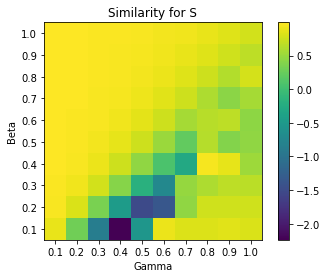

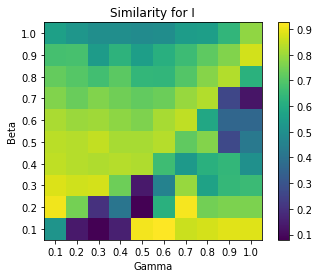

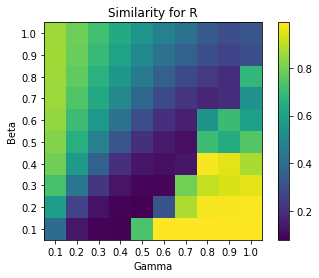

In [732]:
heatmap(np.array(s_matrix), 'Similarity for S')
heatmap(np.array(i_matrix), 'Similarity for I')
heatmap(np.array(r_matrix), 'Similarity for R')

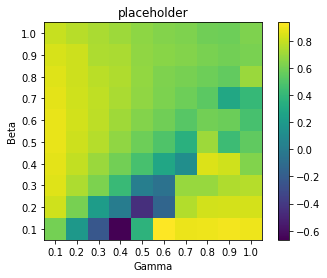

0.937627943561823


In [735]:
overall_similarity = np.array(s_matrix) + np.array(i_matrix) + np.array(r_matrix)
overall_similarity /= 3
heatmap(overall_similarity)
print(np.amax(overall_similarity))  

Max similarity values seen:

- 0.9206843353186623
- 0.8831564691975103
- 0.9161192815500212
- 0.8775065408861421
- 0.885743494827803

with this we can, in the unweighted beta regime, our similarity is appox 88.5%

However, in the weighted beta regime - there will be no difference as were using an unweighted graph in this case. So will need to test for a weighted graph ...

For an exponentially weighted graph we see 89.5% when using weighted beta.
without using weighted beta we see 88.2%

For a power law weighted graph we see 92.3% when using weighted beta.
wihtout using weighted beta we see 91.5%

For linear weighting:
 - weighted beta: 91.5%
 - unweighted beta: 93.7%

Therefore, there is always some small apreciable benefit to using weighted beta -  this is actually a finding (ALHAMDULLILAH)

PROBLEM: linear weighting performs worse when using weighted beta!!!
    -> can justify as this is not typical of real weighted networks - > SOLVED

In [734]:
import numpy as np

# create 2D array
arr = overall_similarity

# find index of highest value
min_index = np.unravel_index(arr.argmin(), arr.shape)
max_index = np.unravel_index(arr.argmax(), arr.shape)

# print index of highest value
print(min_index)
print(max_index)

(3, 0)
(5, 0)


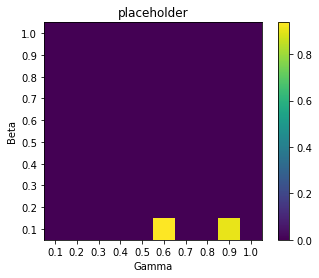

In [743]:
# This sets the values of heatmap to 0 once determined to be below threshold.as_integer_ratio
# making the same profile irrecoverable

import numpy as np

# create 2D array
arr = overall_similarity

# set threshold
threshold = 0.9

# find values below threshold and set them to 0
arr[arr < threshold] = 0

# print updated array

heatmap(arr)


In [318]:
# beta, gamma, threshold for 3d scatter heatmap

simulation_params = {}
simulation_params['Time'] = 50
simulation_params['Runs'] = 50 # low runs to enure doesn't take too long to run
simulation_params['Initial'] = 0.05
simulation_params['Threshold'] = 2.5

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = sir.initialise_weight(H, 1) # give every edge a weight of 1
H = sir.initialise_potential(H, simulation_params)
H = sir.initialise_status(H)

t = np.arange(0, simulation_params['Time'])

s_matrix = []
i_matrix = []
r_matrix = []

for j in range(0,11):
    print(j)
    simulation_params['Beta'] = j/10
    s_matrix.append([])
    i_matrix.append([])
    r_matrix.append([])
    for k in range(0, 11):
        simulation_params['Gamma'] = k/10
        s_matrix[-1].append([])
        i_matrix[-1].append([])
        r_matrix[-1].append([])
        for l in range(1, 21): # currently 22 of threshold will bet tested
            simulation_params['Threshold'] = l*0.5
            #S, I, R = sir.analytic_sol(H, simulation_params)
            s, i, r = sir.smooth(H, simulation_params)
            
            s, temp_S = steady_slice(s, bS)
            i, temp_I = steady_slice(i, bI)
            r, temp_R = steady_slice(r, bR)
            
            s_matrix[-1][-1].append(total_similarity(s, temp_S))
            i_matrix[-1][-1].append(total_similarity(i, temp_I))
            r_matrix[-1][-1].append(total_similarity(r, temp_R))
        

0
1
2
3
4
5
6
7
8
9
10


In [98]:
# Finding region of validity for beta, gamma by finding which give values of threshold that give good similarity with data

simulation_params = {}
simulation_params['Time'] = 50
simulation_params['Runs'] = 100 # low runs to enure doesn't take too long to run
simulation_params['Initial'] = 0.05
simulation_params['Threshold'] = 2.5

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = sir.initialise_weight(H, 1) # give every edge a weight of 1
H = sir.initialise_potential(H, simulation_params)
H = sir.initialise_status(H)

t = np.arange(0, simulation_params['Time'])

s_matrix = [[],[],[]]
i_matrix = [[],[],[]]
r_matrix = [[],[],[]]

for j in range(1,11):
    print(j)
    simulation_params['Beta'] = j/10
    for m in range(3):
        s_matrix[m].append([])
        i_matrix[m].append([])
        r_matrix[m].append([])
    for k in range(1, 11):
        simulation_params['Gamma'] = k/10
        for m in range(3):
            s_matrix[m][-1].append([])
            i_matrix[m][-1].append([])
            r_matrix[m][-1].append([])
        for l in range(4, 25): # currently 21 of threshold will bet tested
            simulation_params['Threshold'] = l*0.25
            S, I, R = sir.analytic_sol(H, simulation_params)
            s, i, r = sir.smooth(H, simulation_params)
            
            s, S = steady_slice(s, S)
            i, I = steady_slice(i, I)
            r, R = steady_slice(r, R)
            
            s_matrix[0][-1][-1].append(dtw_similarity(s, S, 0))
            i_matrix[0][-1][-1].append(dtw_similarity(i, I, 0))
            r_matrix[0][-1][-1].append(dtw_similarity(r, R, 0))
            
            s_matrix[1][-1][-1].append(euclidean_similarity(s, S))
            i_matrix[1][-1][-1].append(euclidean_similarity(i, I))
            r_matrix[1][-1][-1].append(euclidean_similarity(r, R))
            
            s_matrix[2][-1][-1].append(pearson_correlation(s, S, 0))
            i_matrix[2][-1][-1].append(pearson_correlation(i, I, 0))
            r_matrix[2][-1][-1].append(pearson_correlation(r, R, 0))

1


/Users/ali/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ali/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


2
3
4
5
6
7
8
9
10


In [103]:
m=0
overall_similarity = np.array(s_matrix[m]) + np.array(i_matrix[m]) + np.array(r_matrix[m])
overall_similarity /= 3

In [319]:
# create a 3D array with random data
data =  np.array(s_matrix) + np.array(i_matrix) + np.array(r_matrix)
data /= 3

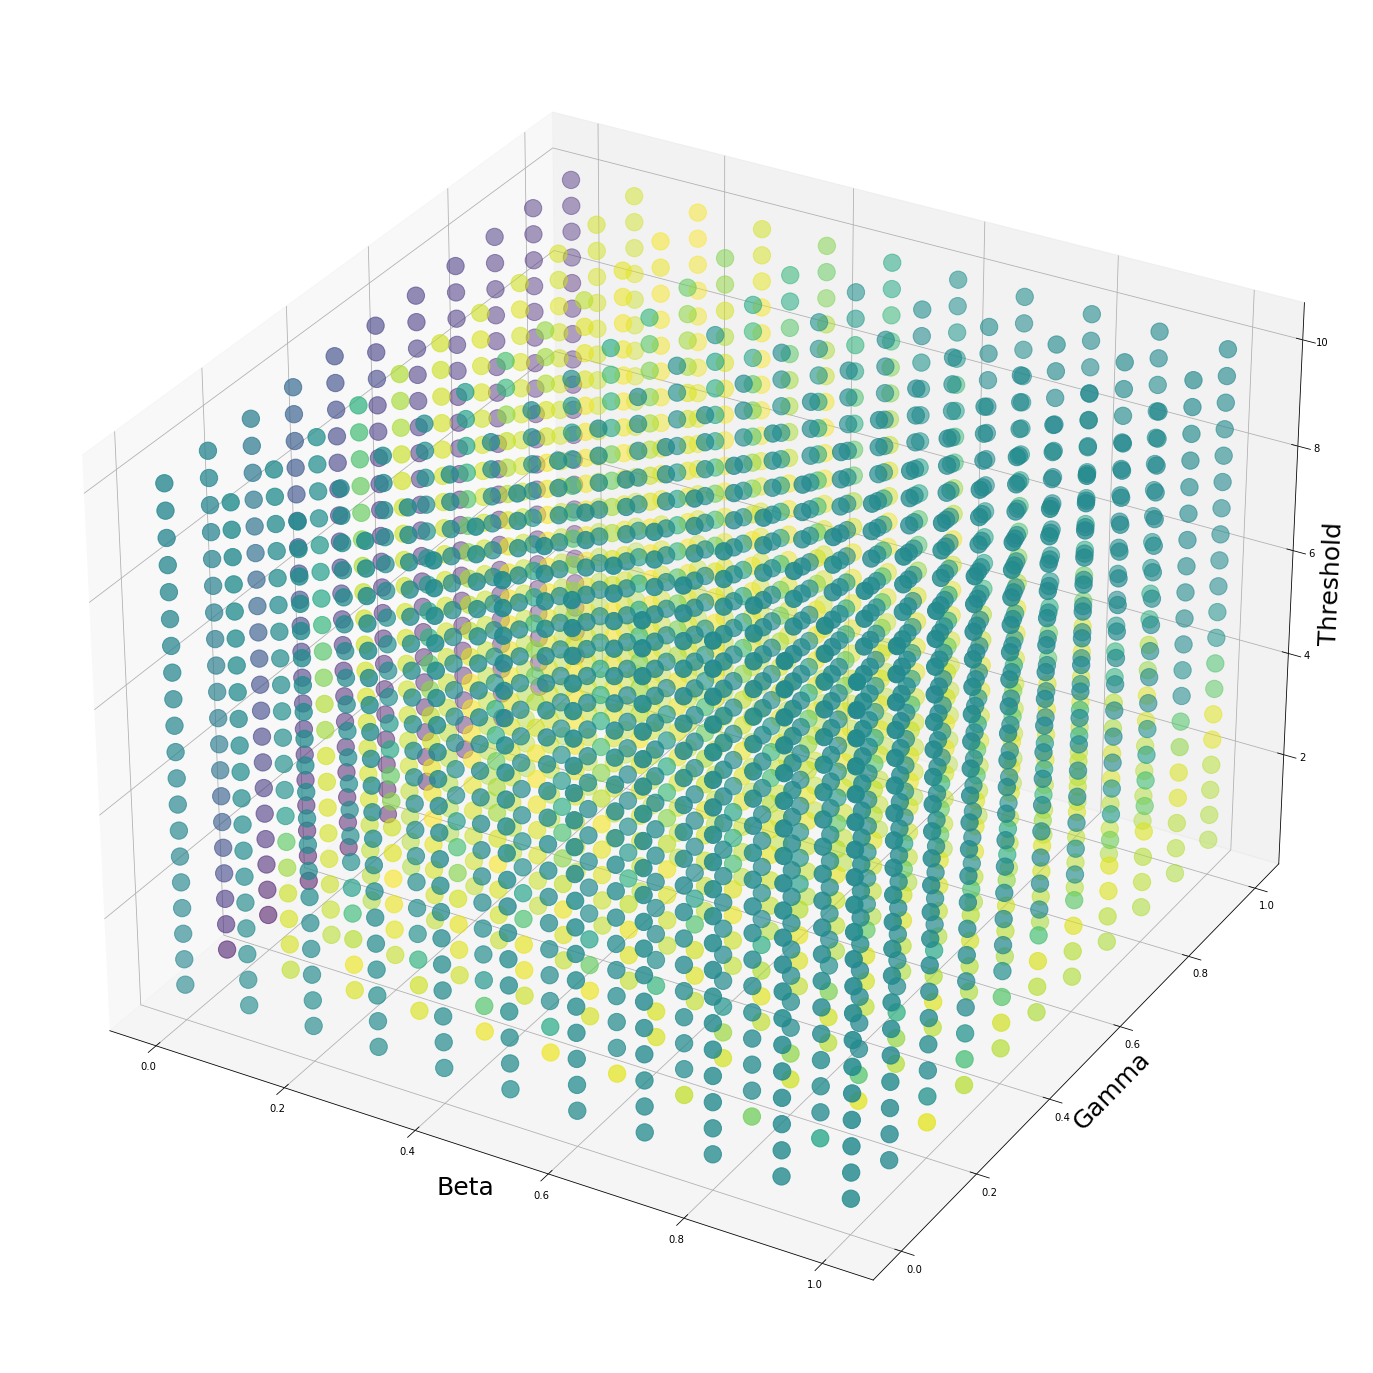

In [338]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['text.usetex'] = False

# create a 3D plot
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')

# plot the data
x, y, z = np.meshgrid(np.arange(0.0, 1.01, 0.1), np.arange(0.0, 1.01, 0.1), np.arange(0.5, 10.01, 0.5))
ax.scatter(x, y, z, s = 300, c=data.flatten())

# set the labels
plt.xlabel('Beta', fontsize = 25)
plt.ylabel('Gamma', fontsize = 25)
ax.set_zlabel('Threshold', fontsize = 25)

# show the plot
plt.show()


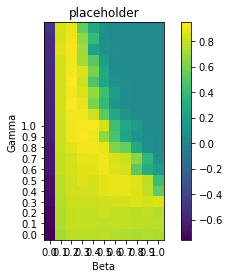

In [349]:
heatmap(data[8])

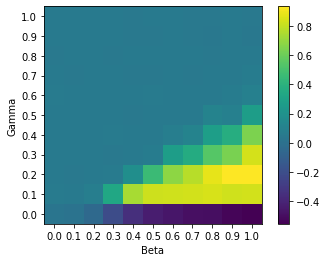

In [373]:
# v = 8
slice_data = data[:,:,19]
heatmap(slice_data, '')

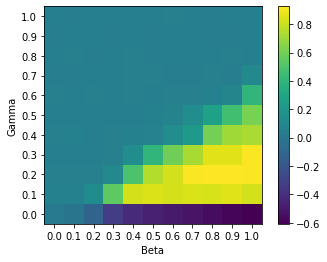

In [372]:
# v = 8
slice_data = data[:,:,15]
heatmap(slice_data, '')

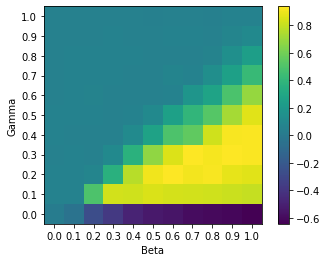

In [370]:
# v = 6
slice_data = data[:,:,11]
heatmap(slice_data, '')

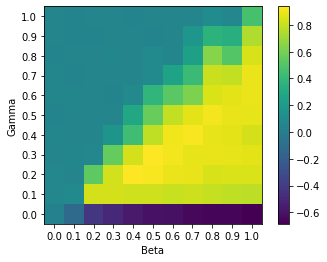

In [371]:
# v = 4
slice_data = data[:,:,7]
heatmap(slice_data, '')

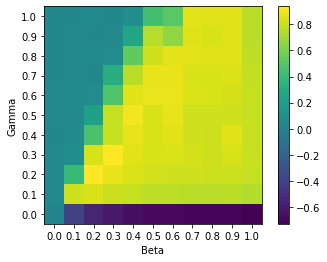

In [368]:
# v = 2
slice_data = data[:,:,3]
heatmap(slice_data, '')

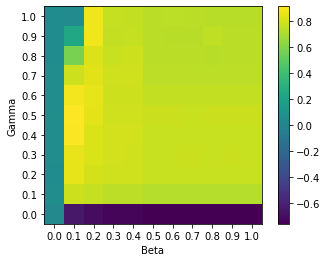

In [374]:
# v = 0
slice_data = data[:,:,0]
heatmap(slice_data, '')

In [274]:
print(len(data))

10


In [ ]:
best_thresh = []

for n in data[0]:
    for m in data[1]:
        

In [323]:
import numpy as np

# create a 3D array with random data

# find the index of the maximum value in the array
max_index = np.unravel_index(np.argmax(data), data.shape)

print('Max value: ', np.amax(data))
print("Index of max value:", max_index)


Max value:  0.9543807729880286
Index of max value: (3, 2, 4)


In [72]:
import numpy as np

# create a 3D array with random data
data = overall_similarity

# define the threshold
threshold = 0.958

# find all values below the threshold
mask = data < threshold

# set those values to 0
data[mask] = 0


from big brain studies, we have shown that best fit is for beta = 0.6, gamma = 0.1, threshold = 2.5

In [ ]:
# Need to find the best threshold value for a particular combination of beta and gamma

# Generating graphs

In [8]:
def metric(arr):
    arr = np.array(arr)
    err = np.std(arr) / np.sqrt(len(arr))
    val = np.mean(arr)
    return val, err

# Basic model

In [9]:
# basic SIR for comparison

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = sir.initialise_weight(H, 1) # give every edge a weight of 1
H = sir.initialise_potential(H, simulation_params)
H = sir.initialise_status(H)

simulation_params['Beta'] = 0.8
simulation_params['Gamma'] = 0.2
simulation_params['Runs'] = 1000
simulation_params['Time'] = 50


bS, bI, bR = smooth_basic(H, simulation_params)

In [15]:
outbreak_size = []
infection_peak = []
time_to_peak = []

for i in range(100):
    simulation_params['Runs'] = 1
    s, i, r = smooth_basic(H, simulation_params)
    i = np.array(i)
    i_size = r[-1]
    i_max = np.amax(i)
    i_max_time = np.argmax(i)
    
    outbreak_size.append(i_size)
    infection_peak.append(i_max)
    time_to_peak.append(i_max_time)
    
metrics = []

metrics.append(metric(outbreak_size))
metrics.append(metric(infection_peak))
metrics.append(metric(time_to_peak))

print(metrics)
simulation_params['Runs'] = 1000

[(0.9703888888888887, 0.0016140872893922985), (0.408, 0.004220262703191664), (8.23, 0.13479985163196584)]


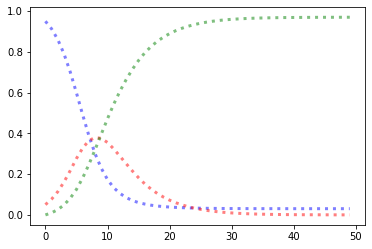

In [12]:
t = np.arange(0, simulation_params['Time'])

plt.plot(t, bS, linewidth = 3, color = 'b', linestyle = 'dotted', alpha = 0.5)
plt.plot(t, bI, linewidth = 3, color = 'r', linestyle = 'dotted', alpha = 0.5) 
plt.plot(t, bR, linewidth = 3,  color = 'g', linestyle = 'dotted', alpha = 0.5)


# Empirical model

In [16]:
G = nm.build_nxgraph(dataset_paths[2], True) # highschool 2012

simulation_params['Beta'] = 0.8
simulation_params['Gamma'] = 0.2

simulation_params['Runs'] = 1000
simulation_params['Time'] = 50
simulation_params['Scheme'] = 'random'
connectivity = 0.137

d, w = ns.analyse_graph(G)
N = len(G)

0.047498122093098845


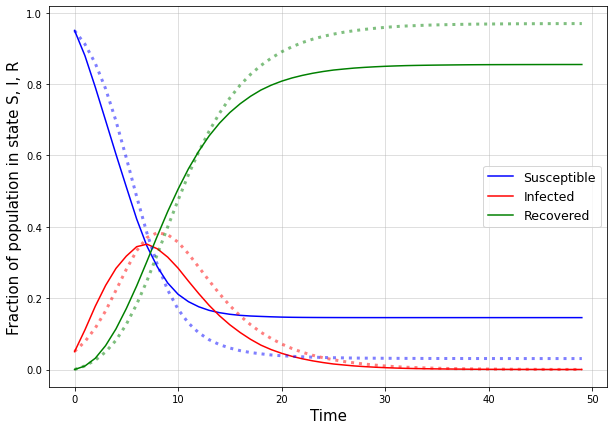

In [38]:
# comparison for highschool

simulation_params['Threshold'] = 3.25
simulation_params['Threshold'] = weighted_beta(G, simulation_params['Threshold'])
s, i, r = sir.smooth(G, simulation_params)
t = np.arange(0, simulation_params['Time'])
print(simulation_params['Threshold'])

plt.figure(figsize = (10,7))
#plt.title('nSIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ') (Threshold = ' + str(round(simulation_params['Threshold'], 2)) + ')')

# numerical
plt.plot(t, s, label = 'Susceptible', color = 'b', lw = 1.5)
plt.plot(t, i, label = 'Infected', color = 'r', lw = 1.5)
plt.plot(t, r, label = 'Recovered', color = 'g', lw = 1.5)

# basic
plt.plot(t, bS, linewidth = 3, color = 'b', linestyle = 'dotted', alpha = 0.5)
plt.plot(t, bI, linewidth = 3, color = 'r', linestyle = 'dotted', alpha = 0.5) 
plt.plot(t, bR, linewidth = 3,  color = 'g', linestyle = 'dotted', alpha = 0.5)

plt.legend(fontsize = 12.5)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Fraction of population in state S, I, R', fontsize = 15)
plt.grid(alpha = 0.5)

In [29]:
node_measures = ns.measure_nodes(G)
network_measures = ns.measure_network(G)
ns.print_dict(node_measures)
ns.print_dict(network_measures)

degree : 24.666666666666668
weight : 0.01585268862612613
closeness : 84.65309407617765
betweenness : 1.1606302178143244
eigenvector : 11.835303981613764


nodes : 180
edges : 2220
ratio : 12.333333333333334
components : 1
density : 0.1378026070763501
path : 2.1477343265052764
diameter : 4
transitivity : 0.4341438783077967




[(0.05111111111111112, 0.0051400148916535), (0.05111111111111112, 0.0051400148916535), (0.0, 0.0)]


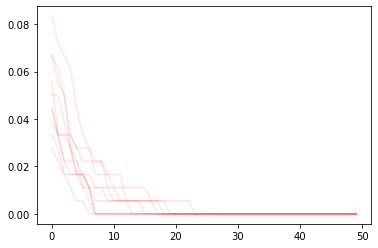

In [17]:
outbreak_size = []
infection_peak = []
time_to_peak = []

for i in range(10):
    simulation_params['Runs'] = 1
    s, i, r = sir.smooth(G, simulation_params)
    plt.plot(t, i, label = 'Infected', color = 'r', lw = 1.5, alpha = 0.1)
    i = np.array(i)
    i_size = r[-1]
    i_max = np.amax(i)
    i_max_time = np.argmax(i)
    
    outbreak_size.append(i_size)
    infection_peak.append(i_max)
    time_to_peak.append(i_max_time)
    
metrics = []

metrics.append(metric(outbreak_size))
metrics.append(metric(infection_peak))
metrics.append(metric(time_to_peak))

print(metrics)
simulation_params['Runs'] = 1000

# Config model

/Users/ali/MSci Project/network_stats.py:101: RuntimeWarning: overflow encountered in power
  return a * ((x)**b)
/Users/ali/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


  best scaling factor    best average error
---------------------  --------------------
                 1.68                  4.24


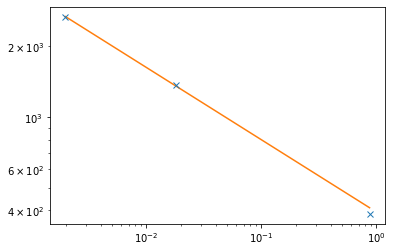

Fit params:  [ 3.93974139e+02 -3.08077480e-01]
Fit error:  [5.43174403 3.04343389]


In [59]:
func = ns.power

scales = np.arange(1.1, 2.0, 0.01)
scale, scale_err = ns.compare_scale(func, w, scales, True, error = False, show_all = False)

error = False
wfit, werr = ns.check_fit(func, ns.log_binning, w, [scale, True, error], error, True, 'log')
print('Fit params: ', wfit)
print('Fit error: ' ,werr)

  best scaling factor    best average error
---------------------  --------------------
                   27                  4.09


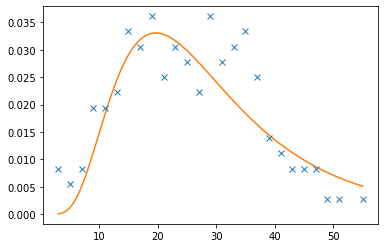

Fit params:  [3.26236767 0.53263717]
Fit error:  [1.34792061 6.83324207]


In [61]:
func = ns.log_normal

test_bins = np.arange(5, 50)
error = False
bins, err = ns.compare_bin_num(func, d, test_bins, error, False)
dfit, derr = ns.check_fit(func, ns.linear_binning, d, [bins, error], error, True, 'linear')
print('Fit params: ', dfit)
print('Fit error: ' ,derr)

In [66]:
import networkx as nx

import scipy.stats as sps

fit = dfit

class degree_distribution(sps.rv_continuous): 
    def _pdf(self, x):
        return ns.log_normal(x, *fit)

ddist = degree_distribution(a=0)

num_nodes = len(G)
connectivity = 0.137

def set_weights(G, num_edges):
    randys = [np.random.uniform(0, 5) for _ in range(num_edges)]
    weight_samples = ns.power(randys, *wfit)
    norm = max(weight_samples)
    weight_samples = weight_samples / norm
    count = 0
    for (i, j) in G.edges():
        G[i][j]['weight'] = weight_samples[count]
        count+=1
    return G

degree_samples = ddist.rvs(size = num_nodes)
degree_samples = np.ceil(degree_samples).astype(int)
C = nx.configuration_model(degree_samples, create_using = nx.Graph)
num_edges = C.number_of_edges()
C = set_weights(C, num_edges)

0.4490485770134777


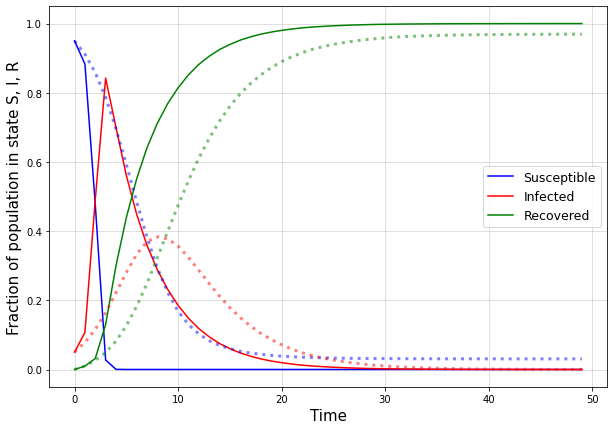

In [72]:
# comparison for config model

simulation_params['Threshold'] = 3.25

C = sir.initialise_potential(H, simulation_params)
C = sir.initialise_status(H)

simulation_params['Threshold'] = weighted_beta(C, simulation_params['Threshold'])
s, i, r = sir.smooth(C, simulation_params)

t = np.arange(0, simulation_params['Time'])
print(simulation_params['Threshold'])

plt.figure(figsize = (10,7))
#plt.title('nSIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ') (Threshold = ' + str(round(simulation_params['Threshold'], 2)) + ')')

# numerical
plt.plot(t, s, label = 'Susceptible', color = 'b', lw = 1.5)
plt.plot(t, i, label = 'Infected', color = 'r', lw = 1.5)
plt.plot(t, r, label = 'Recovered', color = 'g', lw = 1.5)

# analytic
#plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 0.5)
#plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 0.5)
#plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 0.5)

# basic
plt.plot(t, bS, linewidth = 3, color = 'b', linestyle = 'dotted', alpha = 0.5)
plt.plot(t, bI, linewidth = 3, color = 'r', linestyle = 'dotted', alpha = 0.5) 
plt.plot(t, bR, linewidth = 3,  color = 'g', linestyle = 'dotted', alpha = 0.5)

plt.legend(fontsize = 12.5)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Fraction of population in state S, I, R', fontsize = 15)
plt.grid(alpha = 0.5)

In [68]:
node_measures = ns.measure_nodes(C)
network_measures = ns.measure_network(C)
ns.print_dict(node_measures)
ns.print_dict(network_measures)

degree : 28.666666666666668
weight : 0.13755642261647605
closeness : 96.21389673581761
betweenness : 0.8869499717531852
eigenvector : 12.21670661426913


nodes : 180
edges : 2580
ratio : 14.333333333333334
components : 1
density : 0.1601489757914339
path : 1.8770949720670391
diameter : 3
transitivity : 0.2189827622898489




In [ ]:
outbreak_size = []
infection_peak = []
time_to_peak = []

for i in range(1000):
    simulation_params['Runs'] = 1
    s, i, r = sir.smooth(C, simulation_params)
    i = np.array(i)
    i_size = r[-1]
    i_max = np.amax(i)
    i_max_time = np.argmax(i)
    
    outbreak_size.append(i_size)
    infection_peak.append(i_max)
    time_to_peak.append(i_max_time)
    
metrics = []

metrics.append(metric(outbreak_size))
metrics.append(metric(infection_peak))
metrics.append(metric(time_to_peak))

print(metrics)

simulation_params['Runs'] = 1000

# BA model

In [53]:
m = np.ceil(connectivity * ((num_nodes - 1) / 2)).astype('int64')
B = nx.barabasi_albert_graph(num_nodes, m)
num_edges = B.number_of_edges()
B = set_weights(B, num_edges)

0.49975007318985


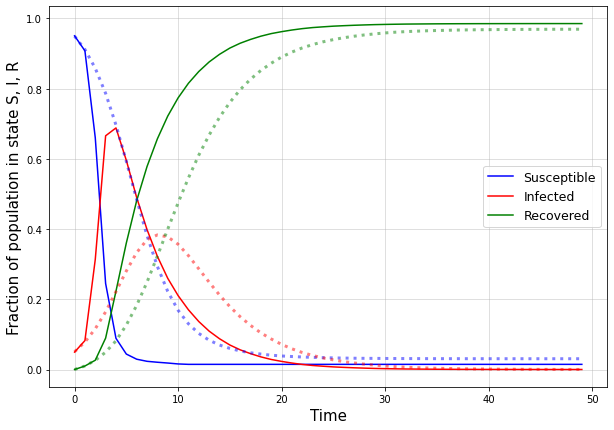

In [69]:
# comparison for BA model

simulation_params['Threshold'] = 3.25

B = sir.initialise_potential(B, simulation_params)
B = sir.initialise_status(B)

simulation_params['Threshold'] = weighted_beta(B, simulation_params['Threshold'])
s, i, r = sir.smooth(B, simulation_params)

t = np.arange(0, simulation_params['Time'])
print(simulation_params['Threshold'])

plt.figure(figsize = (10,7))
#plt.title('nSIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ') (Threshold = ' + str(round(simulation_params['Threshold'], 2)) + ')')

# numerical
plt.plot(t, s, label = 'Susceptible', color = 'b', lw = 1.5)
plt.plot(t, i, label = 'Infected', color = 'r', lw = 1.5)
plt.plot(t, r, label = 'Recovered', color = 'g', lw = 1.5)

# analytic
#plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 0.5)
#plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 0.5)
#plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 0.5)

# basic
plt.plot(t, bS, linewidth = 3, color = 'b', linestyle = 'dotted', alpha = 0.5)
plt.plot(t, bI, linewidth = 3, color = 'r', linestyle = 'dotted', alpha = 0.5) 
plt.plot(t, bR, linewidth = 3,  color = 'g', linestyle = 'dotted', alpha = 0.5)

plt.legend(fontsize = 12.5)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Fraction of population in state S, I, R', fontsize = 15)
plt.grid(alpha = 0.5)

In [70]:
node_measures = ns.measure_nodes(B)
network_measures = ns.measure_network(B)
ns.print_dict(node_measures)
ns.print_dict(network_measures)

degree : 24.255555555555556
weight : 0.1539266761618316
closeness : 94.55672927134174
betweenness : 0.9209089197162763
eigenvector : 11.661611742159668


nodes : 180
edges : 2183
ratio : 12.127777777777778
components : 1
density : 0.13550589695841092
path : 1.9106765983860956
diameter : 3
transitivity : 0.2241946469198777




In [ ]:
outbreak_size = []
infection_peak = []
time_to_peak = []

for i in range(1000):
    simulation_params['Runs'] = 1
    s, i, r = sir.smooth(B, simulation_params)
    i = np.array(i)
    i_size = r[-1]
    i_max = np.amax(i)
    i_max_time = np.argmax(i)
    
    outbreak_size.append(i_size)
    infection_peak.append(i_max)
    time_to_peak.append(i_max_time)
    
metrics = []

metrics.append(metric(outbreak_size))
metrics.append(metric(infection_peak))
metrics.append(metric(time_to_peak))

print(metrics)
simulation_params['Runs'] = 1000